# This code go through folders and files and extract the solution resistance from the fitted data and save all of the Rs in a csv file

In [50]:
# ---------------------------------------------------------------
#  Gather all Rs values from every `fit_params_named.csv`
#  (now numerically sorted: 1 mM → 20 mM, 26 °C → 40 °C, …)
# ---------------------------------------------------------------
from pathlib import Path
import re
import pandas as pd

ROOT_DIR = Path(r"/Volumes/01785304894/Uni Stuff/Measurement_Data/2025/June-July/NPG-500mM-H2SO4-whole")

_num_rx = re.compile(r"(\d+)")          # grab the first integer you see
def _num(path_obj: Path) -> int:
    """Return the first integer in a folder/file name, e.g. '10mM' → 10."""
    m = _num_rx.search(path_obj.name)
    return int(m.group(1)) if m else 0

def collect_rs(root: Path) -> pd.DataFrame:
    rows = []
    # --- concentrations -------------------------------------------------
    for conc_dir in sorted((p for p in root.iterdir() if p.is_dir()),
                           key=_num):
        conc = conc_dir.name              # '2mM', '10mM', …
        # --- temperatures ------------------------------------------------
        for temp_dir in sorted((p for p in conc_dir.iterdir() if p.is_dir()),
                               key=_num):
            temp = temp_dir.name          # '28C', '32C', …
            fitting_dir = temp_dir / "fitting"
            if not fitting_dir.is_dir():
                continue

            # --- measurement folders ------------------------------------
            for meas_dir in sorted((p for p in fitting_dir.iterdir() if p.is_dir()),
                                   key=_num):
                csv_path = meas_dir / "fit_params_named.csv"
                if not csv_path.is_file():
                    continue

                try:
                    df = pd.read_csv(csv_path)
                    mask = df["parameter"].str.strip().str.lower() == "rs"
                    if mask.any():
                        rs_val = float(df.loc[mask, "value"].values[0])
                        rows.append({
                            "concentration": conc,
                            "temperature":  temp,
                            "measurement":   meas_dir.name,
                            "Rs (Ω)":        rs_val
                        })
                except Exception as e:
                    print(f"[warn] could not read {csv_path}: {e}")
    return pd.DataFrame(rows)

# --- run & save -------------------------------------------------
out_df = collect_rs(ROOT_DIR)

out_path = ROOT_DIR / "all_Rs_values.csv"
out_df.to_csv(out_path, index=False)

print(f"✓ collected {len(out_df)} Rs values")
print(f"  saved to: {out_path}")


✓ collected 260 Rs values
  saved to: /Volumes/01785304894/Uni Stuff/Measurement_Data/2025/June-July/NPG-500mM-H2SO4-whole/all_Rs_values.csv


# Next two codes will go through the Rs file and finds the degeneracy and save the tupples with Rs difference in a separate csv file


In [ ]:
"""
Detect “degenerate” solution-resistances in the table produced earlier
(`all_Rs_values.csv`).

A pair of points (C1,T1) and (C2,T2) is called *degenerate* when the
difference between their Rs values is below a user-defined tolerance.

The script supports both an **absolute** and a **relative** criterion:
    • abs(|Rs1 – Rs2|)  < ABS_TOL
    • abs(|Rs1 – Rs2|) / max(Rs1, Rs2) < REL_TOL
You decide which (or both) to enable.
"""
from pathlib import Path
import pandas as pd
import itertools

# ------------------------------------------------------------------
# user settings – tweak to taste
ABS_TOL    = 0.005    # Ω      absolute tolerance (set None to disable)
REL_TOL    = False    # 1 %    relative tolerance  (set None to disable)
DROP_MEAS  = True    # average replicates before comparing? (recommended)
# ------------------------------------------------------------------
CSV_PATH = Path("/Volumes/01785304894/Uni Stuff/Measurement_Data/2025/June-July/NPG-500mM-H2SO4-whole/all_Rs_values.csv")   # path to the table you already built

df = pd.read_csv(CSV_PATH)

# ----- collapse replicates if requested --------------------------------------
if DROP_MEAS:
    df = (df.groupby(["concentration", "temperature"], as_index=False)
            .agg({"Rs (Ω)": "mean"}))          # average Rs per (C,T)

# build a lookup key → Rs
records = df.to_dict("records")
pairs   = list(itertools.combinations(records, 2))

def is_degenerate(r1, r2, abs_tol, rel_tol):
    diff = abs(r1 - r2)
    ok_abs = (abs_tol is not None) and (diff < abs_tol)
    ok_rel = (rel_tol is not None) and (diff / max(r1, r2) < rel_tol)
    return ok_abs or ok_rel

degenerate_rows = []
for a, b in pairs:
    if is_degenerate(a["Rs (Ω)"], b["Rs (Ω)"], ABS_TOL, REL_TOL):
        degenerate_rows.append({
            "conc_T1": f"{a['concentration']}, {a['temperature']}",
            "Rs1 (Ω)": a["Rs (Ω)"],
            "conc_T2": f"{b['concentration']}, {b['temperature']}",
            "Rs2 (Ω)": b["Rs (Ω)"],
            "ΔRs (Ω)": abs(a["Rs (Ω)"] - b["Rs (Ω)"])
        })

out = pd.DataFrame(degenerate_rows)

# ----- save & / or show -------------------------------------------------------
out_file = CSV_PATH.with_name("degenerate_Rs_pairs.csv")
out.to_csv(out_file, index=False)

print(f"✓ found {len(out)} degenerate pairs")
print(f"  saved list to: {out_file}")
print(out.head(10))


✓ found 1 degenerate pairs
  saved list to: /Volumes/01785304894/Uni Stuff/Measurement_Data/2025/June-July/NPG-500mM-H2SO4-whole/degenerate_Rs_pairs.csv
     conc_T1    Rs1 (Ω)    conc_T2    Rs2 (Ω)   ΔRs (Ω)
0  14mM, 34C  49.225267  15mM, 28C  49.221849  0.003418


In [28]:
from pathlib import Path
import pandas as pd
import itertools

# --- SETTINGS ------------------------------------------------------
CSV_PATH = Path("/Volumes/01785304894/Uni Stuff/Measurement_Data/2025/June-July/NPG-500mM-H2SO4-whole/all_Rs_values.csv")
THRESH   = 0.02               # Ω
OUT_CSV  = CSV_PATH.with_name(f"degenerate_Rs_abs<{THRESH}.csv")
# -------------------------------------------------------------------

df = pd.read_csv(CSV_PATH)    # needs: concentration, temperature, Rs (Ω)

rows  = df.to_dict("records")
pairs = itertools.combinations(rows, 2)

degenerate = []
for a, b in pairs:
    # ---------- NEW FILTER ----------                               ↓↓↓↓
    if a["concentration"] == b["concentration"] or a["temperature"] == b["temperature"]:
        continue                      # skip if conc OR temp matches
    # --------------------------------

    dRs = abs(a["Rs (Ω)"] - b["Rs (Ω)"])
    if dRs <= THRESH:
        degenerate.append({
            "Rs Δ (Ω)": dRs,
            "conc_T #1": f"{a['concentration']}, {a['temperature']}",
            "Rs #1 (Ω)": a["Rs (Ω)"],
            "conc_T #2": f"{b['concentration']}, {b['temperature']}",
            "Rs #2 (Ω)": b["Rs (Ω)"],
        })

out = (pd.DataFrame(degenerate)
         .sort_values("Rs Δ (Ω)")
         .reset_index(drop=True))
out.to_csv(OUT_CSV, index=False)

print(f"✓ {len(out)} dissimilar-C&T pairs found (ΔRs ≤ {THRESH} Ω)")
print(f"  saved to: {OUT_CSV}")
print(out.head(10))


✓ 11 dissimilar-C&T pairs found (ΔRs ≤ 0.02 Ω)
  saved to: /Volumes/01785304894/Uni Stuff/Measurement_Data/2025/June-July/NPG-500mM-H2SO4-whole/degenerate_Rs_abs<0.02.csv
   Rs Δ (Ω)  conc_T #1  Rs #1 (Ω)  conc_T #2  Rs #2 (Ω)
0  0.003418  14mM, 34C  49.225267  15mM, 28C  49.221849
1  0.005292  15mM, 48C  42.086475  18mM, 28C  42.081183
2  0.005970  11mM, 48C  55.248418  13mM, 28C  55.242448
3  0.007611  19mM, 40C  36.280359  20mM, 36C  36.272748
4  0.011727  15mM, 48C  42.086475  17mM, 34C  42.098202
5  0.015053  18mM, 40C  37.991943  19mM, 34C  38.006996
6  0.015565  14mM, 46C  44.973433  15mM, 38C  44.957869
7  0.017019  17mM, 34C  42.098202  18mM, 28C  42.081183
8  0.017753  14mM, 40C  46.785911  16mM, 28C  46.803665
9  0.018268  12mM, 48C  50.096067  14mM, 32C  50.114335


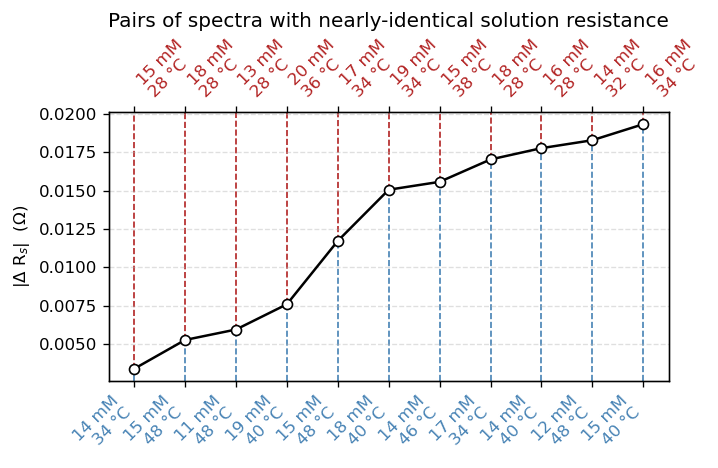

In [48]:


CSV = "/Volumes/01785304894/Uni Stuff/Measurement_Data/2025/June-July/NPG-500mM-H2SO4-whole//degenerate_Rs_abs<0.02.csv"     # path to your file

import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ------------------ 1. load & parse ------------------
csv_path = CSV      #  <— adjust if needed
df = pd.read_csv(csv_path)
df.columns = [c.strip() for c in df.columns]   # strip any spaces

def _parse_ct(text):
    """ "14mM, 32C"  -->  (14, 32) """
    m = re.match(r"\s*(\d+)\s*mM,\s*(\d+)\s*C", str(text))
    return (int(m.group(1)), int(m.group(2))) if m else (np.nan, np.nan)

df[["C1","T1"]] = df["conc_T #1"].apply(lambda s: pd.Series(_parse_ct(s)))
df[["C2","T2"]] = df["conc_T #2"].apply(lambda s: pd.Series(_parse_ct(s)))
df.rename(columns={"Rs Δ (Ω)": "|ΔRs| (Ω)"}, inplace=True)

# optional: sort pairs by |ΔRs| so the smallest differences come first
df = df.sort_values("|ΔRs| (Ω)").reset_index(drop=True)

# ------------------ 2. make the plot ------------------

PLOT_TYPE   = "line"     #  "bar"  or  "line"
LINE_STYLE  = "-o"      #  ignored if PLOT_TYPE is "bar"

x = np.arange(len(df))          # one position per pair
y = df["|ΔRs| (Ω)"].values

fig, ax = plt.subplots(figsize=(6, 4), dpi=120)

if PLOT_TYPE == "bar":
    ax.bar(x, y, color="grey", alpha=0.6, width=0.8, edgecolor="k")
elif PLOT_TYPE == "line":
    ax.plot(x, y, LINE_STYLE, color="black", mfc="white", mec="black")
else:
    raise ValueError("PLOT_TYPE must be 'bar' or 'line'")

ax.set_ylabel("|Δ R$_s$|  (Ω)")
#ax.set_xlabel("1st spectrum in pair")            # bottom axis caption
ax.set_xticks(x)
ax.set_xticklabels([f"{c} mM\n{t} °C" for c, t in zip(df["C1"], df["T1"])],
                   rotation=45, ha="right", color="steelblue")

# ---------- top axis for the 2nd spectrum ----------
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(x)
ax_top.set_xticklabels([f"{c} mM\n{t} °C" for c, t in zip(df["C2"], df["T2"])],
                       rotation=45, ha="left", color="firebrick")
ax_top.xaxis.set_ticks_position('top')
#ax_top.set_xlabel("2nd spectrum in pair", color="firebrick")

ax.grid(axis='y', ls='--', alpha=0.4)
ax.set_title("Pairs of spectra with nearly-identical solution resistance")
fig.tight_layout()

# --------------------------------------------------
# Add two-colour dashed guide lines at every x-tick
# --------------------------------------------------
ymin, ymax = ax.get_ylim()          # current y-limits
for xi, yi, col_bot, col_top in zip(
        x, y,
        ["steelblue"]*len(x),       # colour that matches bottom ticks
        ["firebrick"]*len(x)):      # colour that matches top  ticks

    # segment BELOW the data point (bottom tick’s colour)
    ax.plot([xi, xi], [ymin, yi], ls="--", lw=1, color=col_bot, zorder=0)

    # segment ABOVE the data point (top tick’s colour)
    ax.plot([xi, xi], [yi, ymax], ls="--", lw=1, color=col_top, zorder=0)

# (re-apply limits because adding lines can auto-scale)
ax.set_ylim(ymin, ymax)

plt.show()

